In [1]:
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tifffile

from utils.tools import get_raster_data, save_raster_and_write_meta


In [2]:
clipped_satellite_file = "examples/clipped_satellite.tif"
imgA, _ = get_raster_data(clipped_satellite_file) 
imgA = np.transpose(imgA, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

post_clipped_image_file = "examples/post_clipped_image.tif"
imgB, _  = get_raster_data(post_clipped_image_file) 
imgB = np.transpose(imgB, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

masks_new_edited_file = "sam_output/masks_new_edited.tif"
mask, tif_data = get_raster_data(masks_new_edited_file)
mask = np.transpose(mask, (1, 2, 0)).astype(np.uint8)  

Dataset name: examples/clipped_satellite.tif
File mode: r
Number of bands: 3
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 364, 578)
Data type: uint8
Dataset name: examples/post_clipped_image.tif
File mode: r
Number of bands: 4
Image width: 677 pixels
Image height: 426 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 426, 677)
Data type: uint8
Dataset name: sam_output/masks_new_edited.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


## Can we warp the detection mask?

### Interactive correspondence selection

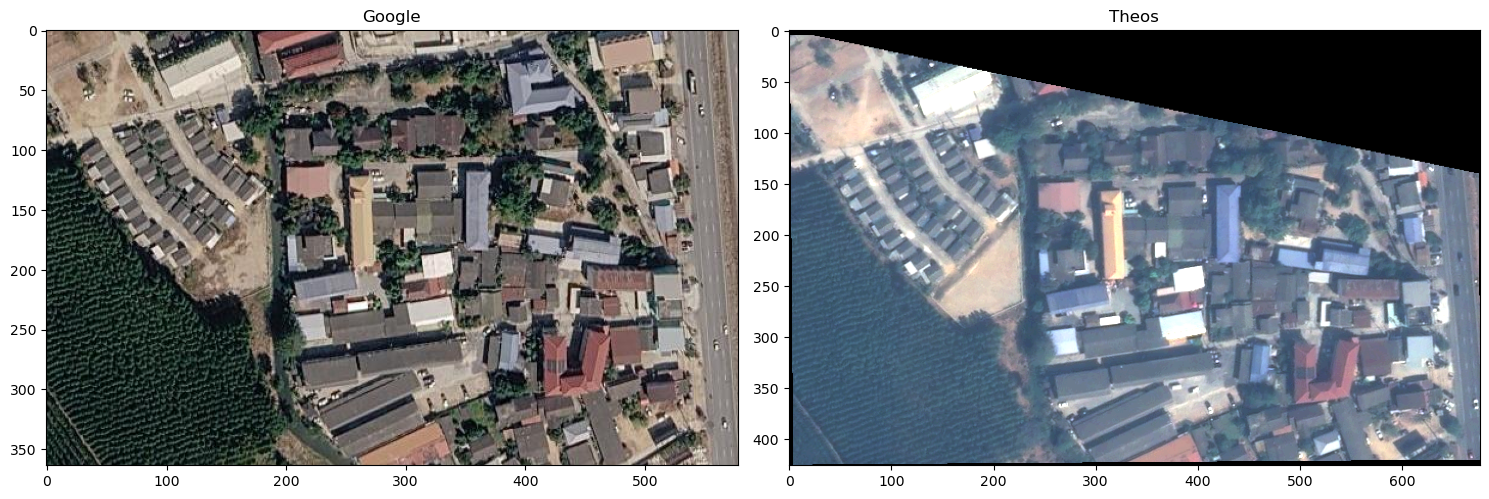

In [3]:
from utils.interactive_tools import Find_correspondences

%matplotlib widget
marker_AB = Find_correspondences(imgA, imgB, figsize=(15, 5))

### Extract homography

In [4]:
import cv2

point_src  = np.array(marker_AB.points[0])
point_dst  = np.array(marker_AB.points[1])

Homography, status = cv2.findHomography(point_src, point_dst)



### Apply homography on the detection mask and Google map

In [5]:
size = (imgB.shape[1], imgB.shape[0])
im_dst = cv2.warpPerspective(imgA, Homography, size)
mask_dst = cv2.warpPerspective(mask, Homography, size)

<bound method Figure.tight_layout of <Figure size 2000x1000 with 6 Axes>>

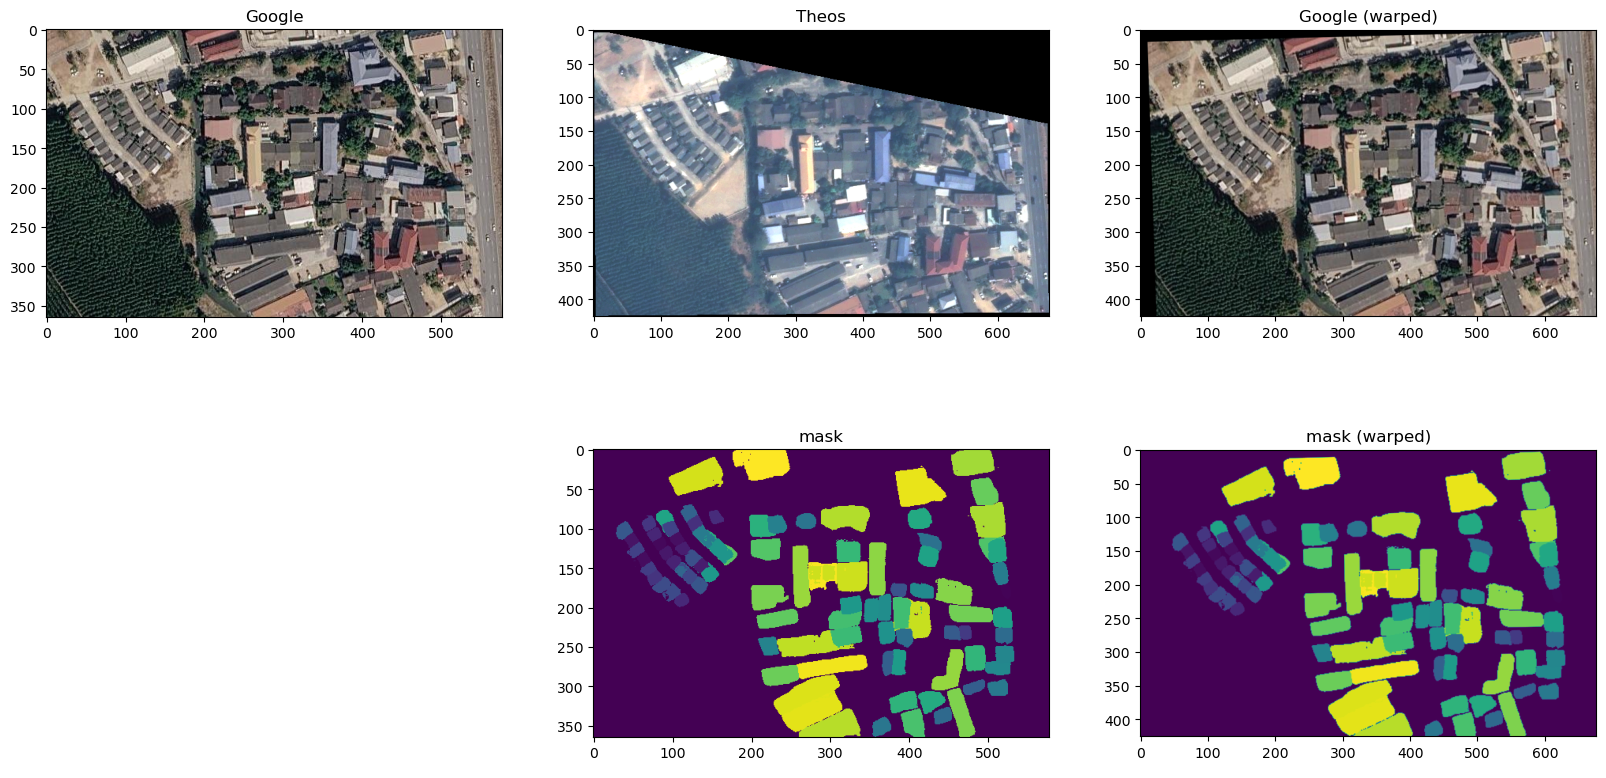

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(20,10)) 
axs[0,0].imshow(imgA[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
axs[0,0].set_title('Google') # Set a title for the first subplot 

axs[0,1].imshow(imgB[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[0,1].set_title('Theos') # Set a title for the second subplot 

axs[0,2].imshow(im_dst[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[0,2].set_title('Google (warped)') # Set a title for the second subplot 

axs[1,0].axis('off')

axs[1,1].imshow(mask)  # Display the first three channels (RGB) of the clipped satellite image
axs[1,1].set_title('mask') # Set a title for the second subplot 

axs[1,2].imshow(mask_dst)  # Display the first three channels (RGB) of the clipped satellite image
axs[1,2].set_title('mask (warped)') # Set a title for the second subplot 

fig.tight_layout

### Save the warped google map and mask

In [7]:
im_dst_4D = np.zeros((imgB.shape[0], imgB.shape[1], 4)) 
im_dst_4D[:,:,:3] = im_dst 
im_dst_4D[:,:, 3] = 253
im_dst_4D = im_dst_4D.transpose(2, 0, 1)
im_dst_4D = im_dst_4D.astype(np.uint8)

In [8]:
destination_tif = "examples/warped_clipped_satellite.tif"
meta_source_tif = post_clipped_image_file
save_raster_and_write_meta(im_dst_4D , destination_tif, meta_source_tif)

Modified image saved to : examples/warped_clipped_satellite.tif


In [9]:
mask_dst_3D = mask_dst.reshape(1, mask_dst.shape[0], mask_dst.shape[1]) 

In [10]:
destination_tif = "examples/warped_masks_new_edited.tif"
meta_source_tif = "sam_output/masks_new_edited.tif"
save_raster_and_write_meta(mask_dst_3D.astype(np.uint32), destination_tif, meta_source_tif)

Modified image saved to : examples/warped_masks_new_edited.tif


### Check the result

In [11]:
import leafmap.leafmap as leafmap
m = leafmap.Map()
m.add_raster(post_clipped_image_file, layer_name="theos") 
m.add_raster(clipped_satellite_file, layer_name="Google") 
m.add_raster("examples/warped_clipped_satellite.tif", layer_name="Google (warped)") 
m.add_raster("examples/warped_masks_new_edited.tif", cmap="jet", layer_name="mask (warped)") 
m

Map(center=[13.053346999999999, 100.924553], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Can we apply SamGeo onto the enhanced theos?

#### An alternative direction

In [12]:
from samgeo import SamGeo2 

In [13]:
sam = SamGeo2(
    model_id="sam2-hiera-large", 
    automatic=False 
)

In [14]:
sam.set_image(post_clipped_image_file)

[ WARN:0@89.447] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 33550 (0x830e) encountered
[ WARN:0@89.447] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 33922 (0x8482) encountered
[ WARN:0@89.447] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 34735 (0x87af) encountered
[ WARN:0@89.447] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 34737 (0x87b1) encountered


In [15]:
sam.show_map()

Map(center=[13.053346999999999, 100.92455100000001], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Can we apply SamGeo onto the warped google map?

In [16]:
from samgeo import SamGeo2 

In [18]:
sam = SamGeo2(
    model_id="sam2-hiera-large", 
    automatic=False
)

In [19]:
image_file = "examples/warped_clipped_satellite.tif"

In [20]:
sam.set_image(image_file)

[ WARN:0@107.490] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 33550 (0x830e) encountered
[ WARN:0@107.490] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 33922 (0x8482) encountered
[ WARN:0@107.490] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 34735 (0x87af) encountered
[ WARN:0@107.490] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 34737 (0x87b1) encountered


In [21]:
sam.show_map()

Map(center=[13.053346999999999, 100.92455100000001], controls=(ZoomControl(options=['position', 'zoom_in_text'…

# Compared with the original Google map

In [ ]:
sam = SamGeo2(
    model_id="sam2-hiera-large", 
    automatic=False,
)

image_file = "examples/clipped_satellite.tif"
sam.set_image(image_file)
sam.show_map()
